<a href="https://colab.research.google.com/github/vidhi-sys/Intelligent-Object-Recognition-and-Query-System-for-Warehouse-Robotics/blob/main/AI_PART2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The classifier was developed using transfer learning with MobileNetV2 to leverage pre-trained ImageNet features for efficient learning on a small warehouse-specific dataset. While transfer learning improves generalization, the model’s performance is constrained by dataset size and diversity.

One major limitation is that the categories (fragile, heavy, hazardous) are visually inferred rather than physically measured. For example, a heavy object cannot be accurately determined solely from visual cues without additional sensor data such as weight measurements. Similarly, hazardous items may require symbol recognition or metadata beyond visual appearance.

Another limitation is potential dataset bias. If the dataset includes synthetic labels (e.g., text overlays like “FRAGILE”), the model may learn textual patterns rather than structural object features. Lighting variations, occlusions, and background clutter can also reduce robustness in real warehouse environments.

Future improvements include expanding the dataset with real-world warehouse images, applying stronger data augmentation, integrating multimodal sensor inputs, and fine-tuning detection and classification jointly for improved spatial awareness.

In [1]:
#pip install torch torchvision scikit-learn matplotlib seaborn


Epoch 1 Loss: 122.3232
Epoch 2 Loss: 80.3709
Epoch 3 Loss: 69.6900

Classification Report:

              precision    recall  f1-score   support

     fragile       0.56      0.89      0.69       106
       heavy       0.85      0.68      0.76       198
   hazardous       0.94      0.83      0.88       198

    accuracy                           0.78       502
   macro avg       0.78      0.80      0.78       502
weighted avg       0.82      0.78      0.79       502



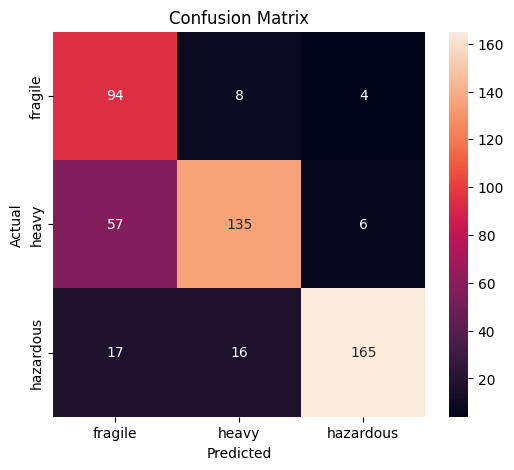

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- TRANSFORM ----------------
transform = transforms.Compose([
    transforms.ToTensor()
])

# ---------------- LOAD CIFAR10 ----------------
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Use smaller subset to avoid RAM crash
train_subset = Subset(train_dataset, range(5000))
test_subset = Subset(test_dataset, range(1000))

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# ---------------- SIMPLE CNN ----------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------- REMAP LABELS ----------------
def remap(label):
    if label == 8:        # ship
        return 0          # fragile
    elif label in [1, 9]: # automobile, truck
        return 1          # heavy
    elif label in [5, 6]: # dog, frog
        return 2          # hazardous
    else:
        return -1

# ---------------- TRAIN ----------------
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        new_labels = []
        new_images = []

        for img, lbl in zip(images, labels):
            mapped = remap(lbl.item())
            if mapped != -1:
                new_images.append(img)
                new_labels.append(mapped)

        if len(new_labels) == 0:
            continue

        images = torch.stack(new_images).to(device)
        labels = torch.tensor(new_labels).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {running_loss:.4f}")

# ---------------- EVALUATION ----------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        for img, lbl in zip(images, labels):
            mapped = remap(lbl.item())
            if mapped == -1:
                continue

            img = img.unsqueeze(0).to(device)
            output = model(img)
            _, pred = torch.max(output, 1)

            all_preds.append(pred.item())
            all_labels.append(mapped)

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["fragile", "heavy", "hazardous"]))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["fragile", "heavy", "hazardous"],
            yticklabels=["fragile", "heavy", "hazardous"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()
